### Lab-06: Softmax Classification



In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1) # 랜덤 시드 고정

##### Softmax
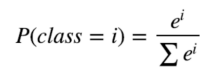

In [40]:
# Softmax
z = torch.FloatTensor([1,2,3])

hypothesis = F.softmax(z, dim=0)
print(hypothesis)

hypothesis.sum()

tensor([0.0900, 0.2447, 0.6652])


tensor(1.)

##### Cross Entropy
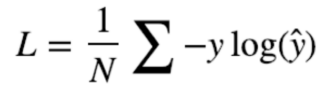

In [41]:
# Cross Entropy Loss (Low-level)
z = torch.rand(3,5,requires_grad=True)
hypothesis = F.softmax(z, dim=1)
print(hypothesis)

y = torch.randint(5, (3,)).long() # 예시를 위해 랜덤하게 정답 설정
print(y)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward>)
tensor([0, 2, 1])


In [42]:
y_one_hot = torch.zeros_like(hypothesis) # |y_one_hot| = (3,5)
y_one_hot.scatter_(1, y.unsqueeze(1), 1)
# .unsqueeze: |y| = (3,) -> (3,1)
# .scatter:dim=1 기준 y.unsqueeze(1)에 1을 뿌려라!!

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [43]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean() # .mean()을 해주면 평균 -> scalar
print(cost)

tensor(1.4689, grad_fn=<MeanBackward0>)


In [44]:
## Cross-entropy Loss with torch.nn.functional

# Low level
torch.log(F.softmax(z, dim=1))

# High level
F.log_softmax(z, dim=1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward>)

In [45]:
# Low level
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

# High level
F.nll_loss(F.log_softmax(z, dim=1), y) # negative log likelihood

F.cross_entropy(z, y)

# Neural Network 에서 확률값 필요
# 예측값을 구하는 과정에서 다시 따로 softmax 함수를 활성화 함수로서 사용

tensor(1.4689, grad_fn=<NllLossBackward>)

In [46]:
x_train = [[1,2,1,1],
           [2,1,3,2],
           [3,1,3,4],
           [4,1,5,5],
           [1,7,5,5],
           [1,2,5,6],
           [1,6,6,6],
           [1,7,7,7]]
y_train = [2,2,2,1,1,1,0,0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

##### Training with Low-level Cross Entropy Loss

In [47]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산 (1)
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1) # or .mm or @
    y_one_hot = torch.zeros_like(hypothesis)
    y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
    cost = (y_one_hot * -torch.log(F.softmax(hypothesis, dim=1))).sum(dim=1).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.901535
Epoch  200/1000 Cost: 0.839114
Epoch  300/1000 Cost: 0.807826
Epoch  400/1000 Cost: 0.788472
Epoch  500/1000 Cost: 0.774822
Epoch  600/1000 Cost: 0.764449
Epoch  700/1000 Cost: 0.756191
Epoch  800/1000 Cost: 0.749398
Epoch  900/1000 Cost: 0.743671
Epoch 1000/1000 Cost: 0.738749


##### Training with F.cross_entropy

In [48]:
# 모델 초기화 
W = torch.zeros((4, 3), requires_grad=True) # dm = 4, calss = 3
b = torch.zeros(1, requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산 (2)
    z = x_train.matmul(W) + b # or .mm or @
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568256
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


##### High-level Implementation with nn.Module

In [49]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) # Output이 3!

    def forward(self, x):
        return self.linear(x)

model = SoftmaxClassifierModel()

In [50]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train) # |x_train| = (m,4)
    # |prediction| = (m,3), |y_train| = (m,)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.849513
Epoch  100/1000 Cost: 0.689894
Epoch  200/1000 Cost: 0.609259
Epoch  300/1000 Cost: 0.551218
Epoch  400/1000 Cost: 0.500141
Epoch  500/1000 Cost: 0.451947
Epoch  600/1000 Cost: 0.405051
Epoch  700/1000 Cost: 0.358733
Epoch  800/1000 Cost: 0.312912
Epoch  900/1000 Cost: 0.269522
Epoch 1000/1000 Cost: 0.241922


##### softmax classification
- 2개 이상의 클래스 분류시 사용 -> 딥러닝시 대부분
- logistic regression 과 매우 유사

- "BCE": 이진 분류, Sigmoid
- "CE": 다중 분류, Softmax